In [23]:
import random
import tensorflow as tf
from tensorflow.keras import layers, utils, models
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [24]:
DATA_DIR = "./sig_images"

In [25]:
def load_data(DATA_DIR=DATA_DIR, test_size=0.3, load_grayscale=True):
    """
        Loads the data into a dataframe.
        
        Arguments:
            DATA_DIR: str
            test_size: float
        Returns:
            (x_train, y_train,x_test, y_test, x_val, y_val, df)
    """
    all_imgs = []
    imgs_forged = []
    imgs_real = []
    features_dict = {}
    labels = [] # forged: 0 and real:
    mode = "rgb"
    if load_grayscale:
        mode = "grayscale"
    
    for folder in os.listdir(DATA_DIR):
        # forged images
        for sub in os.listdir(DATA_DIR+"/forge"):
            if ".Jpeg" not in sub:
                continue
            f = DATA_DIR+"/forge/" + sub
            img = utils.load_img(f, color_mode=mode, target_size=(150,150))
            all_imgs.append(utils.img_to_array(img))
            features_dict[sub] = (img, 0)
            imgs_forged.append(img)
            labels.append(0) # forged

        # real images
        for sub in os.listdir(DATA_DIR+"/real"):
            if ".Jpeg" not in sub:
                continue
            f = DATA_DIR+"/real/" + sub
            print("sub: {}".format(sub))
            img = utils.load_img(f, color_mode=mode, target_size=(150,150))
            all_imgs.append(utils.img_to_array(img))
            features_dict[sub] = (img, 1)
            imgs_real.append(img)
            labels.append(1) # real
            
    features = np.array(all_imgs)
    labels = np.array(labels)
    
    X_train, X_remain, y_train, y_remain = train_test_split(features, labels, test_size=test_size, random_state=228)
    X_valid, X_test, y_valid, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=228)

    
    print ("Generated data.")

    return X_train, X_test, X_valid, y_train, y_test, y_valid, features, labels, features_dict



In [26]:
X_train, X_test, X_valid, y_train, y_test, y_valid, features, labels, features_dict = load_data(load_grayscale=False)

sub: 22T10.Jpeg
sub: 26T2.Jpeg
sub: 32T10.Jpeg
sub: 35T6.Jpeg
sub: 12T19.Jpeg
sub: 10T24.Jpeg
sub: 13T7.Jpeg
sub: 13T34.Jpeg
sub: 22T5.Jpeg
sub: 18T13.Jpeg
sub: 31T1.Jpeg
sub: 38T2.Jpeg
sub: 14T30.Jpeg
sub: 39T37.Jpeg
sub: 27T29.Jpeg
sub: 37T29.Jpeg
sub: 35T14.Jpeg
sub: 29T37.Jpeg
sub: 17T20.Jpeg
sub: 36T12.Jpeg
sub: 34T2.Jpeg
sub: 26T12.Jpeg
sub: 14T26.Jpeg
sub: 27T6.Jpeg
sub: 29T21.Jpeg
sub: 39T21.Jpeg
sub: 12T3.Jpeg
sub: 17T36.Jpeg
sub: 19T28.Jpeg
sub: 39T6.Jpeg
sub: 30T5.Jpeg
sub: 10T32.Jpeg
sub: 23T1.Jpeg
sub: 31T16.Jpeg
sub: 16T4.Jpeg
sub: 13T22.Jpeg
sub: 18T29.Jpeg
sub: 11T6.Jpeg
sub: 18T5.Jpeg
sub: 16T37.Jpeg
sub: 38T20.Jpeg
sub: 28T20.Jpeg
sub: 15T27.Jpeg
sub: 37T7.Jpeg
sub: 27T13.Jpeg
sub: 24T3.Jpeg
sub: 37T13.Jpeg
sub: 15T1.Jpeg
sub: 12T23.Jpeg
sub: 20T17.Jpeg
sub: 30T17.Jpeg
sub: 11T33.Jpeg
sub: 20T4.Jpeg
sub: 29T7.Jpeg
sub: 12T35.Jpeg
sub: 19T1.Jpeg
sub: 10T2.Jpeg
sub: 13T18.Jpeg
sub: 11T25.Jpeg
sub: 33T11.Jpeg
sub: 36T3.Jpeg
sub: 23T11.Jpeg
sub: 16T21.Jpeg
sub: 28T36.Jpeg

In [27]:
#divided by 255: Because the values in the dataset range from 0 to 255.
X_train = X_train/255.0
X_test = X_test/255.0
X_valid = X_valid/255.0

In [28]:
def label_to_text(label=0):
    return "Forged" if label == 0 else "Real"

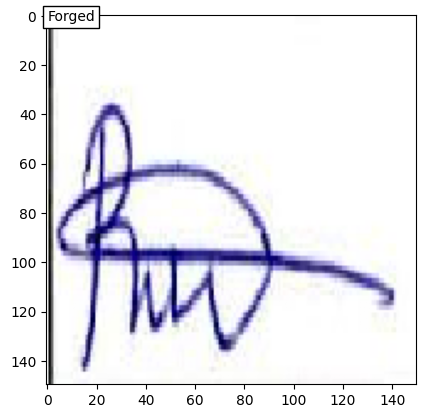

In [29]:
idx = random.randint(0, len(X_train))

plt.imshow(X_train[idx, :])
plt.text(0, 2, label_to_text(labels[idx]), bbox={'facecolor': 'white', 'pad': 3})
plt.show()

In [30]:
def mse(y_true, y_pred):
    return np.square(np.subtract(y_true,y_pred)).mean()

A = features_dict["22T10.Jpeg"]
B = features_dict["22F10.Jpeg"]

A_array = utils.img_to_array(A[0])
B_array = utils.img_to_array(B[0])

print ("MSE Error: {}".format(mse(A_array, B_array)))

MSE Error: 3624.58447265625


## Use Sequential model:
A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

### **Convolution Neutral Network** ref link:
* https://www.youtube.com/@CodingLane
* https://towardsdatascience.com/build-your-first-image-classifier-with-convolution-neural-network-cnn-b4e9034ec5cb

* Tune CNN: https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7

In [31]:
model = models.Sequential()
# how many layer should I use
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(pool_size=3))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 16928)             0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [33]:
history = model.fit(X_train, y_train, epochs= 10, batch_size=100, validation_data = (X_valid, y_valid))

Epoch 1/10


2023-04-16 12:32:00.286346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 0.7782 - accuracy: 0.5296

2023-04-16 12:32:02.372194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 3s 44ms/step - loss: 0.7782 - accuracy: 0.5296 - val_loss: 0.6868 - val_accuracy: 0.5010
Epoch 2/10
46/46 [==============================] - 1s 31ms/step - loss: 0.6358 - accuracy: 0.6396 - val_loss: 0.5772 - val_accuracy: 0.7004
Epoch 3/10
46/46 [==============================] - 1s 30ms/step - loss: 0.5656 - accuracy: 0.7166 - val_loss: 0.5285 - val_accuracy: 0.7335
Epoch 4/10
46/46 [==============================] - 1s 32ms/step - loss: 0.5012 - accuracy: 0.7543 - val_loss: 0.4646 - val_accuracy: 0.7758
Epoch 5/10
46/46 [==============================] - 1s 30ms/step - loss: 0.4239 - accuracy: 0.8118 - val_loss: 0.4048 - val_accuracy: 0.8233
Epoch 6/10
46/46 [==============================] - 1s 30ms/step - loss: 0.3466 - accuracy: 0.8530 - val_loss: 0.4199 - val_accuracy: 0.7975
Epoch 7/10
46/46 [==============================] - 1s 30ms/step - loss: 0.2682 - accuracy: 0.8990 - val_loss: 0.2474 - val_accuracy: 0.9081
Epoch 8/10
46/46 [======

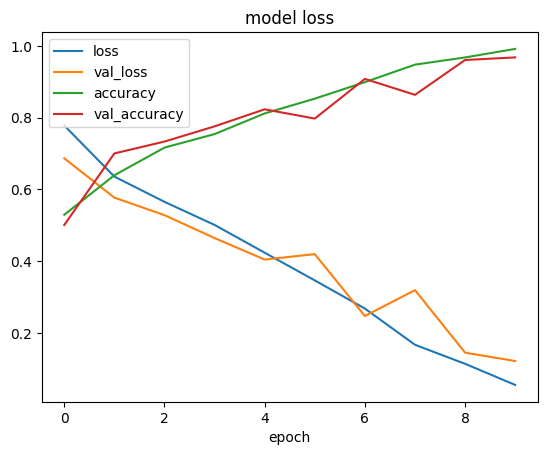

In [38]:
# val_loss: the value of cost function for your cross-validation data
# loss: the value of cost function for your training data.

def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'], loc='upper left')
    plt.show()

plot_history(history)

In [44]:
model.evaluate(X_test, y_test)

31/31 [==============================] - 0s 10ms/step - loss: 0.1114 - accuracy: 0.9711


[0.11137302219867706, 0.9710744619369507]

## Make Prediction for all images

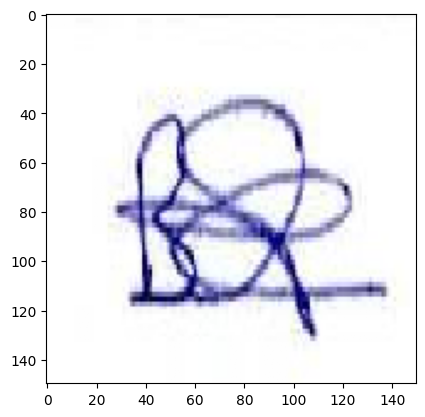

1/1 [==============================] - 0s 12ms/step
prediction: Forged, actual: is Forged


In [45]:
idx2 = random.randint(0, len(features))
plt.imshow(features[idx2, :] / 255.)
plt.show()

y_pred = model.predict(features[idx2, :].reshape(1, 150, 150, 3))
y_pred = 1 if y_pred > 0.5 else 0

print("prediction: {}, actual: is {}".format(label_to_text(y_pred), label_to_text(labels[idx2])))